## ECG signal quality exploration

In [58]:
from __future__ import division
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy.stats import skew, kurtosis, signaltonoise
import itertools
import pickle
import glob
import seaborn as sns
import time
from copy import deepcopy
from sklearn.decomposition import PCA
import random
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


import wfdb

from scipy.signal import medfilt
import pickle
from sklearn.externals import joblib

from savvyecg import ecg_module as em

%matplotlib inline
sns.set()
pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

## Load Data

In [7]:
data_dir = '../data/signal_quality/challenge/2011/set-a/'

filenames = []

data_sigs = {}
data_fields = {}

data_keys = []
for fname in glob.iglob(data_dir + '/*.dat'):#, recursive=True):
    # filename manipulation
    base = os.path.basename(fname)
    key = os.path.splitext(base)[0]
    data_keys.append(key)
    
    # load data
    sig, fields=wfdb.rdsamp(data_dir+key)
    data_fields[key] = fields
    data_sigs[key] = sig[:, [fields['signame'].index(i) for i in fields['signame'] if i in ['II', 'V1', 'V4', 'V5']]]


## ECG leads

In [8]:
print('Available signals from database:'), 
print(fields['signame'])

Available signals from database:
['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


** Placement of ECG electrodes **
<img src="http://www.emtresource.com/wp-content/uploads/2014/04/12-lead-ecg-placement.png" style="width: 250px;"/> 

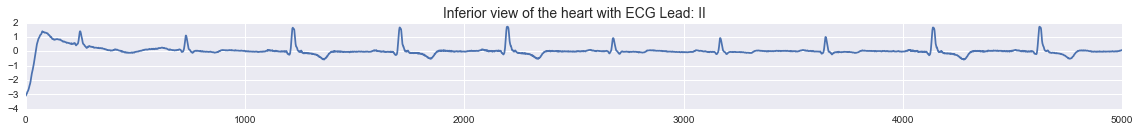

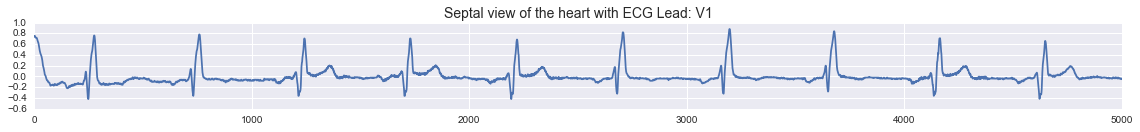

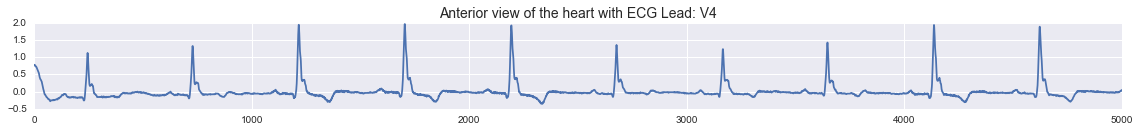

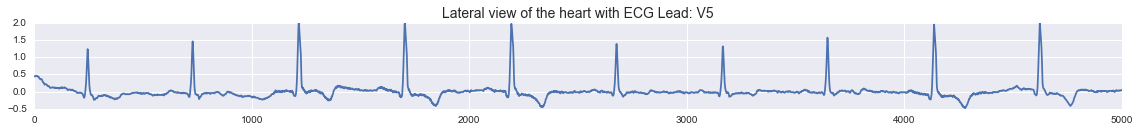

In [9]:
signame = ['II', 'V1', 'V4', 'V5']
view = ['Inferior', 'Septal', 'Anterior', 'Lateral']
for i in range(data_sigs[data_keys[1]].shape[1]):
    plt.figure(figsize=[16, 2])
    plt.plot(data_sigs[data_keys[1]][:, i])
    plt.title(view[i] + ' view of the heart with ECG Lead: ' + signame[i], fontsize = 14)
    plt.tight_layout()


In [10]:
with open(data_dir + 'RECORDS') as f:
    content = f.readlines()
all_data = [x.strip() for x in content] 

with open(data_dir + 'RECORDS-acceptable') as f:
    content = f.readlines()
good_data = [x.strip() for x in content] 

with open(data_dir + 'RECORDS-unacceptable') as f:
    content = f.readlines()
bad_data = [x.strip() for x in content] 

In [11]:
fs, nsamp = fields['fs'], fields['nsamp']

# Collate good signals
good_data_signals = np.empty([1, nsamp])
for key in good_data:
    ecg_signals = data_sigs[key]
    good_data_signals = np.concatenate((good_data_signals, ecg_signals.T), axis = 0)
good_data_signals = good_data_signals[1:]

# Collate bad signals
bad_data_signals = np.empty([1, nsamp])
for key in bad_data:
    ecg_signals = data_sigs[key]
    bad_data_signals = np.concatenate((bad_data_signals, ecg_signals.T), axis = 0)
bad_data_signals = bad_data_signals[1:]

ecg_qlty_data = np.concatenate((good_data_signals, bad_data_signals), axis = 0)
ecg_labels = np.array([1]*len(good_data_signals) + [0]*len(bad_data_signals))

In [12]:
append_curated_data = True

In [13]:
if append_curated_data:
    good_curate = np.loadtxt('../data/signal_quality/curated/good_segments_new2.csv', delimiter=',')
    bad_curate = np.loadtxt('../data/signal_quality/curated/bad_segments.csv', delimiter=',')
    ecg_qlty_data = np.vstack([ecg_qlty_data, good_curate, bad_curate])
    ecg_labels = np.concatenate((ecg_labels, [1]*len(good_curate), [0]*len(bad_curate)))

In [45]:
std_tol = 1e-12
ecg_qlty_data, ecg_labels = em.filter_flat_sigs(ecg_qlty_data, ecg_labels, std_tol=std_tol)

In [46]:
## Divide into 5-second segments of data
divide_data = True

newlen = int(fs*5) # length of 5s-data
if divide_data:
    ecg_qlty_data = np.vstack(np.hsplit(ecg_qlty_data, 2))
    ecg_labels = np.hstack((ecg_labels, ecg_labels))

## Prepare dataframe

In [47]:
saved_data_dir = '../data/signal_quality/'

In [64]:
process_newdata = False
processeddf_fname = saved_data_dir + "ecg_qlty_data_compiled_4ch_5snew.p"

In [65]:
if process_newdata:
    print('Preprocessing ECG signals...'),
    ecg_qlty_data_compiled = pd.DataFrame({'ecg': list(ecg_qlty_data[:100]), 'acceptable' : ecg_labels[:100]})

    ## Process ECG data 
    ecg_qlty_data_compiled['processed'] = ecg_qlty_data_compiled.ecg.apply(lambda x: em.preprocess_ecg(x, fs))

    ## Get R peaks 
    ecg_qlty_data_compiled['r_peaks'] = ecg_qlty_data_compiled.processed.\
                                                apply(lambda x: em.r_peak_loc(x, fs)).values

    ## Get beats for each R peak
    ecg_qlty_data_compiled['beats'] = ecg_qlty_data_compiled.apply(lambda x: [x.processed, x.r_peaks], axis=1)\
                                                            .apply(lambda x: em.ecg_beatsstack(x[0], x[1], fs))
    
    ecg_df = pd.DataFrame.copy(ecg_qlty_data_compiled)
    
    ## Save dataframe
    pickle.dump(ecg_qlty_data_compiled, open(processeddf_fname, "wb" ))
    print('Done!')
    
else:
    ## Load dataframe
    ecg_df = pickle.load( open(processeddf_fname, "rb" ) )

In [66]:
ecg_df.head()

,acceptable,ecg,processed,r_peaks,beats
0,1,"[-3.1, -3.07, -3.04, -3.02, -2.995, -2.955, -2...","[-1.47738786613, -1.45890649888, -1.4403414394...","[249, 731, 1220, 1707, 2197]","[[-0.0577591276617, -0.0664796157257, -0.07610..."
1,1,"[0.74, 0.75, 0.755, 0.755, 0.75, 0.735, 0.73, ...","[0.332026782162, 0.337575638824, 0.34158342667...","[276, 759, 1243, 1729, 2220]","[[0.0269148344316, 0.0390590091271, 0.05102269..."
2,1,"[0.76, 0.77, 0.775, 0.775, 0.76, 0.75, 0.735, ...","[0.352526473735, 0.357344251292, 0.36035672310...","[246, 729, 1217, 1704, 2194]","[[-0.00421216662748, -0.0054524096353, -0.0063..."
3,1,"[0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.4...","[0.1505698415, 0.151670300778, 0.152890911233,...","[246, 729, 1217, 1705, 2195]","[[-0.0340380247102, -0.0375343581413, -0.03943..."
4,1,"[-0.04, -0.015, 0.0, 0.0, 0.0, 0.015, 0.03, 0....","[0.0150296381326, 0.0287263165704, 0.039903248...","[240, 712, 1196, 1674, 2154]","[[0.0453099294192, 0.0423152149451, 0.03646386..."


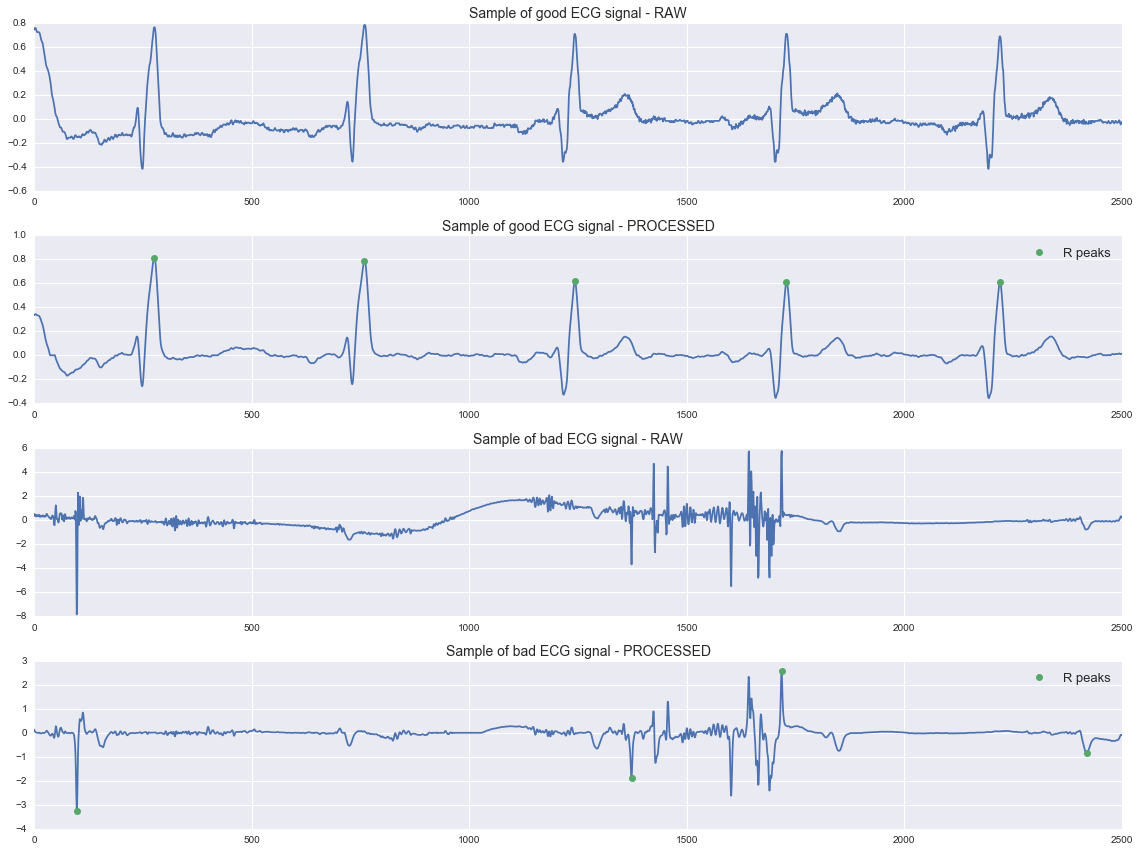

In [67]:
# Plot samples of good and bad signal
sample_good = (ecg_df[ecg_df.acceptable == 1].reset_index()).ix[1]
sample_bad = (ecg_df[ecg_df.acceptable == 0].reset_index()).ix[1]

fig, ax = plt.subplots(4, figsize = [16, 12])
ax[0].plot(sample_good['ecg'])
ax[0].set_title('Sample of good ECG signal - RAW', fontsize=14)
ax[1].plot(sample_good['processed'])
ax[1].plot(sample_good['r_peaks'], (sample_good['processed'])[sample_good['r_peaks']], 'o', label = 'R peaks')
ax[1].set_title('Sample of good ECG signal - PROCESSED', fontsize=14)
ax[1].legend(fontsize = 13)
ax[2].plot(sample_bad['ecg'])
ax[2].set_title('Sample of bad ECG signal - RAW', fontsize=14)
ax[3].plot(sample_bad['processed'])
ax[3].plot(sample_bad['r_peaks'], (sample_bad['processed'])[sample_bad['r_peaks']], 'o', label = 'R peaks')
ax[3].set_title('Sample of bad ECG signal - PROCESSED', fontsize=14)
ax[3].legend(fontsize = 13)
plt.tight_layout()

plt.show()

## Extract features from processed ECG data 

### Features

In [68]:
# Remove samples whose # of rpeaks are < 2
ecg_df_filt = ecg_df.loc[ecg_df.r_peaks.map(len)>1]

In [69]:
process_newfeatures = True
featuresdf_fname = saved_data_dir+"ecg_qlty_features_4ch_powspec.p"

In [70]:
if process_newfeatures:
    ## Compute features
    ecg_df_features = em.get_features(ecg_df_filt, fs)
    
    ## Save features dataframe
    pickle.dump( ecg_df_features, open(featuresdf_fname, "wb" ) )

else:
    ## Load features dataframe
    ecg_df_features = pickle.load( open(featuresdf_fname, "rb" ) ) 

Computing features...
Done!


In [71]:
ecg_df_features.tail(3)

,acceptable,ecg,processed,r_peaks,beats,f_stddev,f_kurtosis,f_skewness,f_rms,f_energy,f_relpower,f_relbasepower,f_powspec0,f_powspec1,f_powspec2,f_powspec3,f_powspec4,f_powspec5,f_powspec6,f_powspec7,f_powspec8,f_powspec9,f_rpeakcount,f_nhr,f_hrv,f_rtor,f_rr,f_sumbe,f_pca,f_mbe,f_maxminbeat
8353,0,"[0.155, 0.2225, 0.29, 0.357500000001, 0.425, 0...","[0.249587588421, 0.333458138322, 0.41875173029...","[451, 893, 1330, 1759, 2180]","[[-0.0267315704759, -0.0318424920823, -0.03677...",0.134713,17.439927,4.107178,0.138370,69.164956,0.881640,0.991385,0.066747,0.960031,0.681622,0.790958,1.207329,1.040147,0.640171,0.647257,0.579294,0.539236,5,1.2,15.960890,864.5,0.591017,271.669427,1.443676,10.938594,1.104010
8354,0,"[0.02, 0.0175, 0.015, 0.00499999999986, -0.005...","[-0.0507437088585, -0.0564447479132, -0.062856...","[248, 659, 1068, 1474, 1876, 2279]","[[-0.00385433748246, -0.00211953208456, 0.0006...",0.137159,17.382970,4.090343,0.140633,69.569740,0.891929,0.995496,0.029247,0.879851,0.591104,0.849639,0.577426,1.050931,1.175235,0.878616,0.676341,0.451162,6,1.2,6.858571,812.4,0.246063,393.653668,1.514456,10.983342,1.094458
8355,0,"[-6.045, -6.0325, -6.02, -6.015, -6.01, -6.02,...","[-0.0324282063335, -0.0258494485638, -0.020652...","[343, 848, 1341, 1818, 2279]","[[-0.0206151784431, -0.0167703439317, -0.00927...",0.164878,26.366663,4.971340,0.166902,52.169115,0.753782,0.970181,0.045184,1.186591,1.473785,1.250696,1.088742,0.925223,1.176357,1.175675,1.353340,1.160750,5,2.0,33.166248,968.0,0.258131,244.113357,-12.451749,9.851227,1.095150


In [72]:
feature_names = [col for col in list(ecg_df_features.keys()) if col[:2] == 'f_']
features_df = ecg_df_features.filter(feature_names)
labels_df = ecg_df_features.filter(['acceptable'])

## Build classifier

In [73]:
features = np.copy(features_df.values)

annotation = ecg_df_features.acceptable.values
annotation = annotation[~np.isinf(features).any(axis=1)]
new_features = features[~np.isinf(features).any(axis=1)]

class_features = new_features
class_labels = annotation
class_features.shape

(8238, 26)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(class_features, class_labels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((5766, 26), (2472, 26))

In [75]:
def train_with_cross_val(X, y, models, n_folds=5, smote_balance = True, 
                        bm_criterion = 'fpr', shuffle_fold = True):
    
    best_model = None
    best_model_name = None
    best_accuracy = 0
    best_fpr = 1

    accuracies = [] # np.zeros([len(models), n_folds])
    false_postivies = []
    
    sm = SMOTE()
    if smote_balance:
        features, labels = sm.fit_sample(X, y)
    else:
        features = X
        labels = y
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=shuffle_fold)
    model_names = sorted(models.keys())
    
    for train_index, test_index in skf.split(features, labels):
        scaler = StandardScaler()
        X_train = scaler.fit_transform(features[train_index, :])
        y_train = labels[train_index]
        X_val = scaler.transform(features[test_index, :])
        y_val = labels[test_index]
        
        fold_accuracies = []
        fold_falsepos = []
        
        for m in model_names: 
            clf = models[m]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            
            evaluation = em.conf_mat_params_binary(y_val, y_pred)
            
            acc = evaluation['accuracy']
            fpr = evaluation['falsepositiverate']
            fold_accuracies.append(acc)
            fold_falsepos.append(fpr)
            
            if bm_criterion == 'fpr':            
                if fpr < best_fpr:
                    best_fpr = fpr
                    mdl = pickle.dumps(clf)
                    best_model = pickle.loads(mdl)
                    best_model_name = m
                    s = pickle.dumps(scaler)
                    best_model_scaler = pickle.loads(s)
            else:         
                if acc > best_accuracy:
                    best_accuracy = acc
                    mdl = pickle.dumps(clf)
                    best_model = pickle.loads(mdl)
                    best_model_name = m
                    s = pickle.dumps(scaler)
                    best_model_scaler = pickle.loads(s)
                
        accuracies.append(fold_accuracies)
        false_postivies.append(fold_falsepos)
        
    acc_results = np.vstack(accuracies)
    fpr_results = np.vstack(false_postivies)

    out = pd.DataFrame({'model': model_names})
    
    for n in np.arange(n_folds):
        out['cv'+str(n+1)+'_acc'] = acc_results[n]
    out['cv_acc_mean'] = out[[col for col in list(out.keys()) if col[-3:] == 'acc']].mean(axis=1)
    
    for n in np.arange(n_folds):
        out['cv'+str(n+1)+'_fpr'] = fpr_results[n]
    out['cv_fpr_mean'] = out[[col for col in list(out.keys()) if col[-3:] == 'fpr']].mean(axis=1)

    f = open('ecg_qlty_classifier.p', 'wb')
    pickle.dump(best_model, f)
    f.close()
    
    f = open('ecg_qlty_scaler.p', 'wb')
    pickle.dump(best_model_scaler, f)
    f.close()

    return out, [best_model_name, best_model, best_model_scaler]

In [76]:
models = {"Nearest Neighbors": KNeighborsClassifier(5, weights='distance', p=1),
          "Random Forest": RandomForestClassifier(n_estimators=300, n_jobs=-1)} 

result_df_balanced, best_model_params = train_with_cross_val(X_train, y_train, models, n_folds=6, shuffle_fold = True,
                                                            smote_balance=True, bm_criterion='fpr')

In [77]:
print('Best model: ' + best_model_params[0])
result_df_balanced

Best model: Nearest Neighbors


,model,cv1_acc,cv2_acc,cv3_acc,cv4_acc,cv5_acc,cv6_acc,cv_acc_mean,cv1_fpr,cv2_fpr,cv3_fpr,cv4_fpr,cv5_fpr,cv6_fpr,cv_fpr_mean
0,Nearest Neighbors,0.885790,0.869190,0.884462,0.868526,0.880984,0.884973,0.878988,0.026560,0.027888,0.035857,0.035857,0.035904,0.025266,0.031222
1,Random Forest,0.923639,0.920983,0.930279,0.911687,0.921543,0.912899,0.920171,0.090305,0.088977,0.087649,0.103586,0.093085,0.095745,0.093225


## Evaluate performance on Test set

In [78]:
X_test_stdized = best_model_params[2].transform(X_test)
out = em.conf_mat_params_binary(y_test, best_model_params[1].predict(X_test_stdized))

In [79]:
print('Accuracy \t\t: {}'.format(out['accuracy']))
print('False Positive Rate\t: {}'.format(out['falsepositiverate']))

Accuracy 		: 0.8001618122977346
False Positive Rate	: 0.17741935483870963
